In [4]:
from datasets import load_dataset, Features, Value, ClassLabel
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding
from transformers import TextClassificationPipeline
from scipy.stats import pearsonr
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.nn as nn
from time import localtime, strftime, strptime
import os
import seaborn as sns

In [5]:
CL = 5

f = {f"{k}{i}": Value(dtype="string") for k in "ts" for i in range(CL)}
dataset = load_dataset("csv", 
                       data_files={split: f"../D0/{split}.csv" for split in ["train", "val", "test"]},
                       features=Features({
                            **f,
                            "labels": ClassLabel(num_classes=8, names=["neutral", "joy", "sadness", "fear", "anger", "surprise", "disgust", "non-neutral"])
                       }))

aug_dataset = load_dataset("csv", 
                       data_files={split: f"../D2/{split}.csv" for split in ["train", "val", "test"]},
                       features=Features({
                            **f,
                            "labels": ClassLabel(num_classes=8, names=["neutral", "joy", "sadness", "fear", "anger", "surprise", "disgust", "non-neutral"])
                       }))

In [6]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

def preprocess_data(examples):
    convs = [
        tokenizer.apply_chat_template(
            [{"role": "system", "content": f"How does {examples[f's{CL-1}'][x]} feel at the end of the conversation?"}] + \
            [{"role": examples[f"s{i}"][x], "content": examples[f"t{i}"][x] + " "} for i in range(CL)], 
            tokenize=False)
        for x in range(len(examples["labels"]))
    ]

    encoding = tokenizer(convs, max_length=512, truncation=True)

    return encoding

def mask_all(examples):
    return {f"t{CL-1}": [tokenizer.mask_token for i in range(len(examples[f"t{CL-1}"]))]}

tokenized_dataset = dataset.map(preprocess_data, batched=True, batch_size=100000,
                                remove_columns=[f"{k}{i}" for k in "ts" for i in range(CL)])

tokenized_aug_dataset = aug_dataset.map(preprocess_data, batched=True, batch_size=100000,
                                remove_columns=[f"{k}{i}" for k in "ts" for i in range(CL)])

tokenized_masked_dataset = dataset.map(mask_all, batched=True, batch_size=100000).map(preprocess_data, batched=True, batch_size=100000,
                                remove_columns=[f"{k}{i}" for k in "ts" for i in range(CL)])

tokenized_masked_aug_dataset = aug_dataset.map(mask_all, batched=True, batch_size=100000).map(preprocess_data, batched=True, batch_size=100000,
                                remove_columns=[f"{k}{i}" for k in "ts" for i in range(CL)])


data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [7]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    metrics = {
        "WA": accuracy_score(labels, predictions).tolist(),
        "UWA": balanced_accuracy_score(labels, predictions).tolist(),
        "miF1": f1_score(labels, predictions, average="micro"),
        "maF1": f1_score(labels, predictions, average="macro"),
        "wtF1": f1_score(labels, predictions, average="weighted"),
    }

    return metrics

In [8]:
loss_fn = nn.CrossEntropyLoss(torch.Tensor(1/np.bincount(dataset["train"]["labels"])).to("cuda"))
# loss_fn = nn.CrossEntropyLoss()

class MaskedTrainer(Trainer):
    rng = np.random.default_rng(42)
    endl_token = tokenizer.encode('\n')[1]
    mask_token = tokenizer.mask_token_id
    eos_token = tokenizer.eos_token_id
    pad_token = tokenizer.pad_token_id

    mask_ratio = 0.5

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)

        loss = loss_fn(outputs["logits"], labels)
        return (loss, outputs) if return_outputs else loss
    
    def training_step(self, model, inputs):
        mask_idx = self.rng.choice(len(inputs["input_ids"]), int(self.mask_ratio * len(inputs["input_ids"])), replace=False)
        for i in mask_idx:
            s = (inputs["input_ids"][i] == self.endl_token).nonzero()[-2].item()
            e = (inputs["input_ids"][i] == self.eos_token).nonzero()[-1].item()

            inputs["input_ids"][i][s+2:s+11] = inputs["input_ids"][i][e-8:e+1].clone()
            inputs["input_ids"][i][s+1] = self.mask_token
            inputs["input_ids"][i][s+11:e+1] = self.pad_token
            inputs["attention_mask"][i][s+11:e+1] = 0

        
        return super().training_step(model, inputs)

In [9]:
def get_checkpoint(epoch=0, run="latest", folder_path="results"):
    if run == "latest":
        run = max(os.listdir(folder_path), key=lambda x: strptime(x, "%b-%d-%y-%H:%M:%S"))

    checkpoint = sorted(os.listdir(f"{folder_path}/{run}"), key=lambda x: int(x.split("-")[1]))[epoch-1]

    return f"{folder_path}/{run}/{checkpoint}"

c = get_checkpoint(32)
model = AutoModelForSequenceClassification.from_pretrained(c)

In [10]:
training_args = TrainingArguments(
    output_dir="/tmp/tmp_trainer",
    per_device_eval_batch_size=64,
    report_to="none",
)

trainer = MaskedTrainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,

)

In [8]:
trainer.evaluate(tokenized_dataset["test"])

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


  0%|          | 0/31 [00:00<?, ?it/s]

{'eval_loss': 1.4886226654052734,
 'eval_WA': 0.4516293279022403,
 'eval_UWA': 0.5050396741833976,
 'eval_miF1': 0.4516293279022403,
 'eval_maF1': 0.3570450692405388,
 'eval_wtF1': 0.45239254615199065,
 'eval_runtime': 5.354,
 'eval_samples_per_second': 366.825,
 'eval_steps_per_second': 5.79}

In [9]:
predictions = trainer.predict(tokenized_dataset["test"])

  0%|          | 0/31 [00:00<?, ?it/s]

In [10]:
preds = pd.DataFrame(dataset["test"])
preds["pred"] = np.argmax(predictions[0], axis=1)

In [11]:
preds

t0  \
0     Why do all you're coffee mugs have numbers on ...   
1     Oh. That's so Monica can keep track. That way ...   
2                                          Y'know what?   
3                                            It didn't.   
4     Okay, so what you used to have with Rachel, is...   
...                                                 ...   
1959  I don't know what it is, I just can't take a g...   
1960                            Oh, here's a great one.   
1961                             Yeah, I'm not in that.   
1962                   I know, but look at me: all tan.   
1963  Hey, why don't you guys go get portraits done ...   

                                                     t1  \
0     Oh. That's so Monica can keep track. That way ...   
1                                          Y'know what?   
2                                            It didn't.   
3     Okay, so what you used to have with Rachel, is...   
4                      Now, wh-what, what is that like?   
...                                                 ...   
1959                            Oh, here's a great one.   
1960                             Yeah, I'm not in that.   
1961                   I know, but look at me: all tan.   
1962  Hey, why don't you guys go get portraits done ...   
1963  That's a good idea! I bet they have one of tho...   

                                                     t2  \
0                                          Y'know what?   
1                                            It didn't.   
2     Okay, so what you used to have with Rachel, is...   
3                      Now, wh-what, what is that like?   
4     It's so cool man, it's so, it's just 'cause be...   
...                                                 ...   
1959                             Yeah, I'm not in that.   
1960                   I know, but look at me: all tan.   
1961  Hey, why don't you guys go get portraits done ...   
1962  That's a good idea! I bet they have one of tho...   
1963  Yeah that's great! Next to that, Chandler won'...   

                                                     t3  \
0                                            It didn't.   
1     Okay, so what you used to have with Rachel, is...   
2                      Now, wh-what, what is that like?   
3     It's so cool man, it's so, it's just 'cause be...   
4                                           Yeah, yeah.   
...                                                 ...   
1959                   I know, but look at me: all tan.   
1960  Hey, why don't you guys go get portraits done ...   
1961  That's a good idea! I bet they have one of tho...   
1962  Yeah that's great! Next to that, Chandler won'...   
1963                          Chandler what do you say?   

                                                     t4        s0        s1  \
0     Okay, so what you used to have with Rachel, is...      Mark    Rachel   
1                      Now, wh-what, what is that like?    Rachel    Rachel   
2     It's so cool man, it's so, it's just 'cause be...    Rachel      Ross   
3                                           Yeah, yeah.      Ross     Frank   
4                                Why can't I find that?     Frank      Joey   
...                                                 ...       ...       ...   
1959  Hey, why don't you guys go get portraits done ...  Chandler    Monica   
1960  That's a good idea! I bet they have one of tho...    Monica  Chandler   
1961  Yeah that's great! Next to that, Chandler won'...  Chandler    Monica   
1962                          Chandler what do you say?    Monica    Phoebe   
1963  All right, but I should warn you, I'm not goin...    Phoebe    Monica   

            s2      s3        s4  labels  pred  
0       Rachel    Ross     Frank       1     0  
1         Ross   Frank      Joey       5     5  
2        Frank    Joey     Frank       1     1  
3         Joey   Frank      Ross       0     0  
4        Frank    Ross 

In [12]:
for i in range(8):

    tp = (preds["labels"] == i) & (preds["pred"] == i)
    tn = (preds["labels"] != i) & (preds["pred"] != i)

    # print((sum(tp) + sum(tn))/len(preds))
    print(str(sum(tp) / sum(preds["labels"] == i)) + ", ")

0.4751131221719457, 
0.8267326732673267, 
0.676923076923077, 
0.5, 
0.5702479338842975, 
0.6794258373205742, 
0.2653061224489796, 
0.04656862745098039, 


In [13]:
sum([0.4751131221719457, 
0.8267326732673267, 
0.676923076923077, 
0.5, 
0.5702479338842975, 
0.6794258373205742, 
0.2653061224489796, 
])/7

0.5705355380023144

In [14]:
sum([0.8267326732673267, 
0.676923076923077, 
0.5, 
0.5702479338842975, 
0.6794258373205742, 
0.2653061224489796, 
])/6

0.5864392739740425

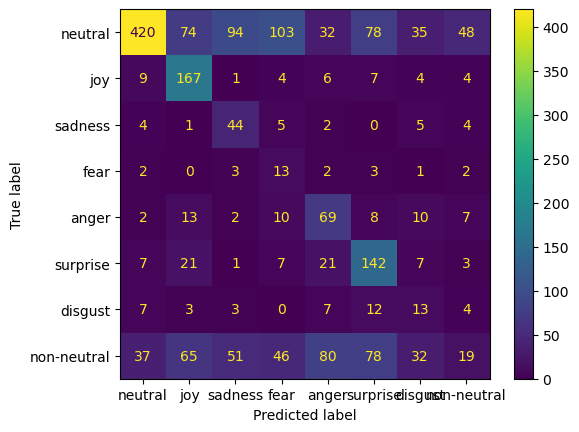

In [15]:
ConfusionMatrixDisplay.from_predictions(preds["labels"], preds["pred"], display_labels=dataset["train"].features["labels"].names)

In [11]:
label_names = dataset["train"].features["labels"].names
cm = confusion_matrix(preds["labels"], preds["pred"])
norm_cm = cm / cm.sum(1)[:, np.newaxis]
df_cm = pd.DataFrame(norm_cm, index=label_names, columns=label_names)
sns.heatmap(df_cm, annot=cm, fmt="", cmap="Purples")

NameError: name 'preds' is not defined

In [12]:
from transformers import pipeline

model.to("cpu")
pipe = pipeline("text-classification", model=model, tokenizer=tokenizer)

In [13]:
text_inputs = [
    [
        "My car just broke.", 
        "Mine's broken too. We can't go anywhere.", 
        "What about his?", 
        "Also broken. We're stuck.",
        "great",
    ], [
        "Let's go to the party.", 
        "Sure!", 
        "Are you ready?", 
        "I'm ready. Let's go.",
        "great",
    ],
]

role_names = ["A", "B"]
convs = [
    tokenizer.apply_chat_template(
        [{"role": "system", "content": f"How does {role_names[0]} feel at the end of the conversation?"}] + \
        [{"role": role_names[i % 2], "content": x + " "} for i, x in enumerate(m)], 
        tokenize=False)
    for m in text_inputs
]

logits = pipe(convs)
for i in logits: print(i)


No chat template is defined for this tokenizer - using a default chat template that implements the ChatML format (without BOS/EOS tokens!). If the default is not appropriate for your model, please set `tokenizer.chat_template` to an appropriate template. See https://huggingface.co/docs/transformers/main/chat_templating for more information.



{'label': 'LABEL_2', 'score': 0.6975295543670654}
{'label': 'LABEL_0', 'score': 0.36742570996284485}


In [14]:
outputs = torch.softmax(model(**tokenizer(convs, return_tensors="pt", padding=True)).logits, dim=-1)

In [15]:
outputs

tensor([[0.0273, 0.0349, 0.6975, 0.0598, 0.0108, 0.0376, 0.1121, 0.0200],
        [0.3674, 0.1317, 0.0483, 0.1296, 0.0206, 0.1492, 0.0541, 0.0991]],
       grad_fn=<SoftmaxBackward0>)

In [16]:
from matplotlib import rcParams

rcParams['figure.figsize'] = 8, 1.6

[Text(0.5, 0, 'Probability (%)')]

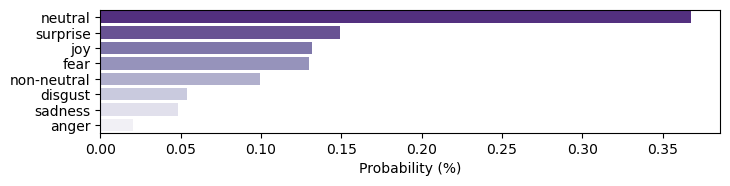

In [17]:
data = sorted(zip(outputs.tolist()[1], label_names), reverse=True)
g = sns.barplot(y=[d[1] for d in data], x=[d[0] for d in data], orient="h", palette="Purples_r")
g.set(xlabel='Probability (%)')

In [23]:
raise Exception

Exception: 

In [ ]:
p = []

for i in range(31, 41):
    c = get_checkpoint(i)
    model = AutoModelForSequenceClassification.from_pretrained(c)

    training_args = TrainingArguments(
        output_dir="/tmp/tmp_trainer",
        per_device_eval_batch_size=64,
        report_to="none",
    )

    trainer = MaskedTrainer(
        model=model,
        args=training_args,
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,

    )

    predictions = trainer.predict(tokenized_dataset["test"])

    scores = compute_metrics(predictions[:2])

    preds = pd.DataFrame(dataset["test"])
    preds["pred"] = np.argmax(predictions[0], axis=1)

    abc = []
    for i in range(8):
        tp = (preds["labels"] == i) & (preds["pred"] == i)
        tn = (preds["labels"] != i) & (preds["pred"] != i)

        # print((sum(tp) + sum(tn))/len(preds))
        abc.append(sum(tp) / sum(preds["labels"] == i))

    p.append(f"WA: {scores['WA']} UWA: {scores['UWA']} f: {sum(abc[1:7])/6}")

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

In [ ]:
for x in p:
    print(x)

WA: 0.45824847250509165 UWA: 0.49684182075693933 f: 0.572932131044446
WA: 0.4516293279022403 UWA: 0.5050396741833976 f: 0.5864392739740425
WA: 0.4623217922606925 UWA: 0.5032976889532758 f: 0.5808172303187971
WA: 0.4714867617107943 UWA: 0.5009438865034904 f: 0.5728397119191838
WA: 0.47046843177189407 UWA: 0.4995620186638129 f: 0.5712171812450637
WA: 0.464867617107943 UWA: 0.4995054616641672 f: 0.5734042153511169
WA: 0.4694501018329939 UWA: 0.5024941008667072 f: 0.5764463828549561
WA: 0.46741344195519346 UWA: 0.49759601884905086 f: 0.569695647052631
WA: 0.4679226069246436 UWA: 0.4990479768474009 f: 0.5714744769227286
WA: 0.46741344195519346 UWA: 0.4990715439665562 f: 0.5714744769227286
